In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [ ]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

In [2]:
##GEORGIA GA
##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Yearly data/Flats' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

##Bands and indices

df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') ##make sure no other sensors are being used

df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4'])) ##ndvi conditional based on whether sensor is Landsat-5 or 8

df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])

df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

##DAYMET data added - yearly averages
##PC:
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)

dm['ident'] = dm['Latitude']/dm['Longitude']

##Seasonal averages: growing season (defined as between 3/1 and 10/31)
path3 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Growing season' 
all_files3 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files3:
    dm2 = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm2)

dm2 = pd.concat(li, axis=0, ignore_index=True)

dm2['ident'] = dm2['Latitude']/dm2['Longitude']

dm2 = dm2.rename(
    columns={
        'dayl': 'sn_dayl', 'prcp': 'sn_prcp', 'srad': 'sn_srad','tmax': 'sn_tmax','tmin': 'sn_tmin','vp': 'sn_vp'
    }
)

##Loading elevation data
elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Point_elevation/DEM_vals_10m.csv')

elev_10m.rename(columns={'first':'Elevation'}, inplace=True)

## drop rows which have same lat and long and keep latest entry
dfx = elev_10m.drop_duplicates(
  subset = ['Latitude', 'Longitude'],
  keep = 'last').reset_index(drop = True)

dfx = dfx[['Elevation', 'Latitude', 'Longitude']]
dfx['ident'] = dfx['Latitude']/dfx['Longitude']

df['ident'] = df['Latitude']/df['Longitude'] 

##Merging elevation point data with band dataset prior to model development
df0 = pd.merge(df, dfx, on = 'ident')
df0_sn = pd.merge(df0, dm2)
df1 = pd.merge(df0_sn, dm)

df1 = df1[df1['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
df1 = df1[df1['prcp'].notna()] ##CAREFUL; added 7/11/22
df1 = df1[df1['Species_Code'] == 'A1'] ##careful here
df1 = df1[(df1['flats'] < 0.1) & (df1['flats'] > -0.1)] ##Increases NRMSE by 0.003, but seems to be a better fit

ga_df1 = df1.copy()

ga_df1['Date'] = pd.to_datetime(ga_df1.Date, format='%m/%d/%Y')
ga_df1['DOY'] = ga_df1['Date'].dt.strftime('%j') ##Add day of year (DOY) to dataset

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics

xargs=ga_df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b','wdrvi5', 'savi', 
        'Elevation', 'tmax', 'tmin', 'sn_tmax', 'sn_tmin', 'DOY' 
    ]
]

#removed: 'nd_r_g','dayl','sn_prcp', 'sn_dayl', 'sn_srad', 'sn_vp', 'vp', 'srad', 'prcp'

yargs=df1['Plant_Biomass'] 

size_x = 0.2
seed = 0
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test - NOT NEEDED IN IMPLEMENTATION?
# # Pipeline example:
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

Mean Absolute Error: 266.6631692414698
Mean Squared Error: 162014.76842528238
Root Mean Squared Error: 402.51058175566317
The r squared is: 0.2747188301635315
testing r2 is: 0.2747188301635315
training r2 is: 0.9132729790386299
NRMSE is: 0.13495654069567453


In [3]:
##Virginia VA

##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Yearly point extraction data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') 
df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4']))
df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])
df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

df = df.drop(columns=['latitude','longitude'])
df['ident'] = df['Latitude'] / df['Longitude'] + df['Year'] 

##DAYMET data
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/VA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)
dm.rename(columns={'site_id':'siteName'}, inplace=True)
dm = dm.drop(columns=['latitude','longitude'])
dm['ident'] = dm['Latitude'] / dm['Longitude'] + dm['Year']

##Seasonal averages: growing season (defined as between 3/1 and 10/31)
path3 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/VA/Growing season' 
all_files3 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files3:
    dm2 = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm2)

dm2 = pd.concat(li, axis=0, ignore_index=True)

dm2['ident'] = dm2['Latitude']/dm2['Longitude']

dm2 = dm2.rename(columns={'dayl': 'sn_dayl', 'prcp': 'sn_prcp', 'srad': 'sn_srad', \
                        'tmax': 'sn_tmax','tmin': 'sn_tmin','vp': 'sn_vp', 'swe': 'sn_swe'})

##TBD: Seasonal averages/growing season (defined as between 3/1 and 10/31)

##Loading elevation data
elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Point elevation/VA_DEM_vals_10m.csv')
elev_10m.rename(columns={'first':'Elevation'}, inplace=True)
elev_10m.rename(columns={'site_id':'siteName'}, inplace=True)
elev_10m['ident'] = elev_10m['Latitude'] / elev_10m['Longitude'] + elev_10m['Year']

##Merging daymet, elevation, and flats data
df['dropident'] = df['Latitude']/df['Longitude']*df['Year']+df['liveMass']
dm['dropident'] = dm['Latitude']/dm['Longitude']*dm['Year']+dm['liveMass']
dm2['dropident'] = dm2['Latitude']/dm2['Longitude']*dm2['Year']+dm2['liveMass']
elev_10m['dropident'] = elev_10m['Latitude']/elev_10m['Longitude']*elev_10m['Year']+elev_10m['liveMass']

dm0 = pd.merge(dm, dm2, on = ['dropident'], how = 'left')

dm0 = dm0.drop(dm0.loc[:, 'system:index_y':'ident_y'].columns, axis=1)

dm0.columns = [
    'dayl','prcp','srad','swe','tmax','tmin','vp','system:index','marshName','siteName', 'Latitude', 
    'Code', 'Longitude', 'monitoringPurpose', 'Replicate','Year', 'speciesName','locationID','liveMass','Transect','ident',
    'dropident', 'sn_dayl', 'sn_prcp', 'sn_srad', 'sn_swe', 'sn_tmax', 'sn_tmin', 'sn_vp'
]

##Merge daymet with remote sensing data:

df0 = pd.merge(df, dm0, on = ['dropident'], how = 'left')

df0['dropident'] = df0['Latitude_x']/df0['Longitude_x']*df0['Year_x']+df0['liveMass_x']
print(len(df0['dropident']))
df0 = df0.drop_duplicates(
  subset = ['dropident'],
  keep = 'last').reset_index(drop = True)
print(len(df0['dropident']))

##Merge with elevation
df1 = pd.merge(df0, elev_10m, on = ['dropident'], how = 'left')

df1['dropident'] = df1['Latitude_x']/df1['Longitude_x']*df1['Year_x']+df1['liveMass_x']
print(len(df1['dropident']))
df1 = df1.drop_duplicates(
  subset = ['dropident'],
  keep = 'last').reset_index(drop = True)
print(len(df1['dropident']))

##THIS NEEDS TO BE 0
print('df0 biomass diff is: '+str(sum(df0['liveMass_x'] - df0['liveMass_y'])))
print('df1 biomass diff (x-y) is: '+str(sum(df1['liveMass_x'] - df1['liveMass_y'])))
print('df1 biomass diff (x-z) is: '+str(sum(df1['liveMass_x'] - df1['liveMass'])))
# df1.rename(columns={'liveMass_x':'liveMass'}, inplace=True)

print("biomass measurements: " + str(len(df1['liveMass'])))
print(len(df1['Elevation'].unique()))

df1 = df1.drop(columns = ['latitude', 'longitude']) ##lower case ones are the older values

##Some more data massaging
df1 = df1[df1['ndvi'].notna()]
df1 = df1[df1['liveMass'].notna()]
df1 = df1[df1['Latitude'].notna()]
df1 = df1[(df1['flats'] < 0.1)] ##Double check

##Group df1 and average (midpoint) the replicates (a/b)
df_temp=df1.copy()

df_temp = df_temp.groupby(['Year','locationID','Transect','Latitude','Longitude'],as_index = False).aggregate(
    {
        'liveMass':[np.mean, np.size],'ndvi':[np.mean],'nd_swir2_r':[np.mean],'nd_swir2_nir':[np.mean],'nd_g_b':[np.mean],
        'nd_r_g':[np.mean],'wdrvi5':[np.mean],'savi':[np.mean],'Elevation':[np.mean],'prcp':[np.mean],'dayl':[np.mean],
        'tmax':[np.mean],'tmin':[np.mean],'srad':[np.mean],'vp':[np.mean], 'sn_prcp':[np.mean],'sn_dayl':[np.mean],
        'sn_tmax':[np.mean],'sn_tmin':[np.mean],'sn_srad':[np.mean],'sn_vp':[np.mean], 'collectDate':'first'
    }
)

df_temp.columns = [
    'Year','locationID','Transect','Latitude','Longitude','liveMass','N','ndvi','nd_swir2_r','nd_swir2_nir', 'nd_g_b', 
    'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl','tmax','tmin','srad','vp','sn_prcp', 'sn_dayl','sn_tmax','sn_tmin',
    'sn_srad','sn_vp', 'collectDate'
]

# display(df_temp)

##Machine learning
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics

df1 = df_temp.copy() ##Therein the rub! COMMENT OUT if you do not want to group replicates
va_df1 = df_temp.copy()

va_df1['DOY'] = pd.to_datetime(va_df1['collectDate']).apply(lambda x: x.strftime('%j')if not pd.isnull(x) else '')
va_df1 = va_df1.drop(df1.index[0:205]) ##Add day of year (DOY) to dataset, but loses data

print("biomass measurements: " + str(len(df1['liveMass'])))

xva=va_df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl', 'tmax', 'tmin',
        'srad', 'vp', 'sn_prcp', 'sn_dayl','sn_tmax','sn_tmin','sn_srad','sn_vp', 'DOY'
    ]
]

yva=va_df1['liveMass'] 

size_x = 0.2
seed = 3
xva_train, xva_test, yva_train, yva_test = train_test_split(xva, yva, test_size=size_x, random_state = seed) 
## 80% training and 20% test

VApipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
VApipe.fit(xva_train, yva_train)
va_pred=VApipe.predict(xva_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yva_test, va_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yva_test, va_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yva_test, va_pred)))
r_square = metrics.r2_score(yva_test, va_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(VApipe.score(xva_test, yva_test)))
print('training r2 is: ' + str(VApipe.score(xva_train, yva_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yva_test, va_pred))/np.ptp(yva_test)))

# Mean
print('MEAN BASELINE:')
va_pred_mean = [np.mean(yva_train)] * len(yva_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yva_test, va_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yva_test, va_pred_mean)))

1972
1846
1864
1846
df0 biomass diff is: 0.0
df1 biomass diff (x-y) is: 0.0
df1 biomass diff (x-z) is: 0.0
biomass measurements: 1846
153
biomass measurements: 611


C:\Users\arj26323\AppData\Local\Temp\ipykernel_14704\4093856654.py:130: FutureWarning: The provided callable <function mean at 0x00000185317A1900> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df_temp = df_temp.groupby(['Year','locationID','Transect','Latitude','Longitude'],as_index = False).aggregate(
C:\Users\arj26323\AppData\Local\Temp\ipykernel_14704\4093856654.py:130: FutureWarning: The provided callable <function mean at 0x00000185317A1900> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df_temp = df_temp.groupby(['Year','locationID','Transect','Latitude','Longitude'],as_index = False).aggregate(


Mean Absolute Error: 244.24950829268283
Mean Squared Error: 111109.41674810486
Root Mean Squared Error: 333.3307917791347
The r squared is: 0.20567296165316518
0.20567296165316518
testing r2 is: 0.20567296165316518
training r2 is: 0.8688111441189659
NRMSE is: 0.18078703257832554
MEAN BASELINE:
Mean Absolute Error: 273.3046363545116
Root Mean Squared Error: 375.47884626115405


,B1,B2,B3,B4,B5,B6,B7,flats,system:index,Site,...,srad,tmax,tmin,vp,DOY,lter,locationID,Transect,N,collectDate
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0.019625,0.0,1.0,...,342.593597,25.048056,14.132274,1776.901489,285,GA,NaN,NaN,NaN,NaN
1,0.0263,0.0404,0.0351,0.0745,0.0697,0.2883,0.0448,0.033653,0.0,1.0,...,342.510712,25.575659,14.795082,1762.035522,290,GA,NaN,NaN,NaN,NaN
3,0.0344,0.0429,0.0374,0.0798,0.0649,0.2951,0.0362,0.095547,0.0,1.0,...,340.148438,25.406548,14.338548,1778.461426,299,GA,NaN,NaN,NaN,NaN
4,0.0240,0.0361,0.0321,0.0872,0.0559,0.2947,0.0309,0.049471,0.0,1.0,...,338.359924,25.079752,14.206429,1799.670776,297,GA,NaN,NaN,NaN,NaN
5,0.0598,0.0626,0.0610,0.1112,0.0979,0.2968,0.0613,0.004838,0.0,1.0,...,351.314453,26.066071,14.187940,1683.812134,289,GA,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,307.891052,20.562885,11.365109,1535.228271,226,VA,3.0,A,2.0,2017-08-14
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,308.119415,20.968325,11.728791,1573.322876,226,VA,3.0,B,2.0,2017-08-14
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,310.027924,20.746950,11.474368,1548.789673,226,VA,3.0,B,2.0,2017-08-14
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,307.995300,21.011868,11.759917,1576.207886,226,VA,3.0,C,2.0,2017-08-14


Mean Absolute Error: 263.69421327306327
Mean Squared Error: 145674.22128368265
Root Mean Squared Error: 381.67292448336264
The r squared is: 0.47755850040596914
0.47755850040596914
testing r2 is: 0.47755850040596914
training r2 is: 0.8954486528185714
NRMSE is: 0.11228739034753092
MEAN BASELINE:
Mean Absolute Error: 358.51575473603583
Root Mean Squared Error: 528.0858835707412


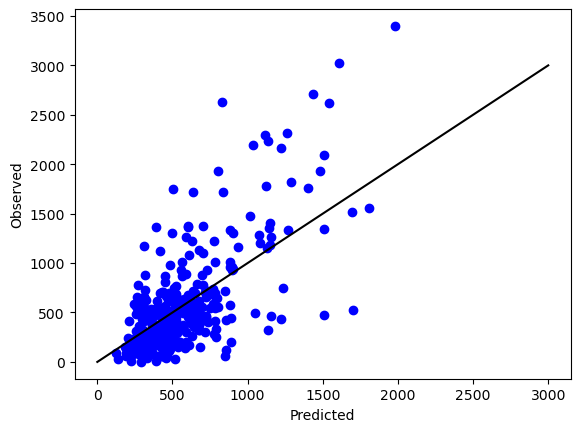

test data correlation coefficient is: 0.7008222851853717
train data correlation coefficient is: 0.9622448828393498


RandomForestRegressor(n_estimators=65, random_state=0)

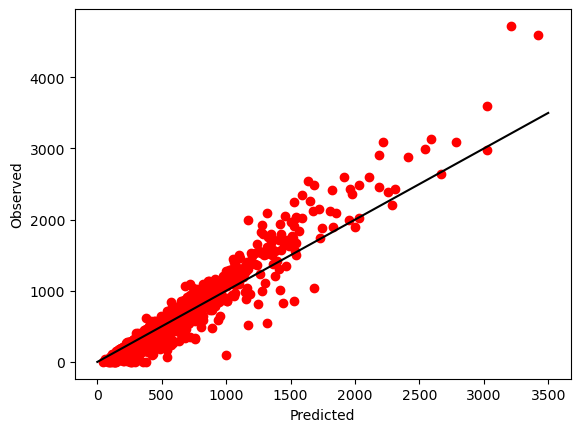

In [4]:
##Combining the datasets

ga_df1.rename(columns={'Plant_Biomass':'liveMass'}, inplace=True)

ga_df1['lter'] = 'GA'
va_df1['lter'] = 'VA'

combined_df = pd.concat([ga_df1, va_df1])

display(combined_df)

combined_df = combined_df[combined_df['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
combined_df = combined_df[combined_df['prcp'].notna()] ##CAREFUL; added 7/11/22

# from sklearn.model_selection import train_test_split
# from numpy import loadtxt
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score

xcomb=combined_df[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', 'tmax', 'tmin',
        'sn_tmax','sn_tmin'
    ]
]
#removed: 'nd_r_g','dayl','sn_prcp', 'sn_dayl', 'sn_srad', 'sn_vp', 'vp', 'srad', 'prcp'
##DOY!!!

# ##Include lag variables (e.g. lag ndvi), precip, temp, more

ycomb=combined_df['liveMass'] 

size_x = 0.2
seed = 3
xcomb_train, xcomb_test, ycomb_train, ycomb_test = train_test_split(xcomb, ycomb, test_size=size_x, random_state = seed) 
## 80% training and 20% test

# # Pipeline example:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe_comb = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe_comb.fit(xcomb_train, ycomb_train)
comb_pred=pipe_comb.predict(xcomb_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(ycomb_test, comb_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ycomb_test, comb_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ycomb_test, comb_pred)))
r_square = metrics.r2_score(ycomb_test, comb_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe_comb.score(xcomb_test, ycomb_test)))
print('training r2 is: ' + str(pipe_comb.score(xcomb_train, ycomb_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(ycomb_test, comb_pred))/np.ptp(ycomb_test)))

# Mean
print('MEAN BASELINE:')
comb_pred_mean = [np.mean(ycomb_train)] * len(ycomb_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(ycomb_test, comb_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ycomb_test,comb_pred_mean)))

plt.scatter(comb_pred, ycomb_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3000], [0, 3000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(ycomb_test, comb_pred)[0, 1]))

train_predcomb = pipe_comb.predict(xcomb_train) ##Not sure if this is the right thing to do here
plt.scatter(train_predcomb, ycomb_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3500], [0, 3500], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_predcomb, ycomb_train)[0, 1]))

##Can we remove this and use pipeline in the future?
from sklearn.ensemble import RandomForestRegressor
reg_x=RandomForestRegressor(n_estimators=65, random_state = 0) ##Won't let me do 100
# reg_x.fit(xargs_train, yargs_train)
reg_x.fit(xcomb, ycomb) ##training using all of the data! Splits/k-fold was for model development, not implementation

In [5]:
##GEE
ee.Initialize()

#Landsat GA
ga17 = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_016038_20171016')
ga19 = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_017038_20190927')
ga20 = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_016038_20201008') ##Tide and cloud not checked

##Landsat VA
va17 = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_014034_20170831')

def maskL5sr(image):
  ## Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloudShadowBitMask = 1 << 3
  cloudsBitMask = 1 << 5

  ##Get the pixel QA band.
  qa = image.select('pixel_qa')

  ##Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
      .And(qa.bitwiseAnd(cloudsBitMask).eq(0))

  ##Return the masked image, scaled to reflectance, without the QA bands.
  return image.updateMask(mask).divide(10000) \
      .select("B[0-9]*") \
      .copyProperties(image, ["system:time_start"])

##Water masking

##Load or import the Hansen et al. forest change dataset.
hansenImage = ee.Image('UMD/hansen/global_forest_change_2015')

##Select the land/water mask.
datamask = hansenImage.select('datamask')

##Create a binary mask.
watermask = datamask.eq(1)

##GA
gamasked17 = ee.Image(maskL5sr(ga17)).updateMask(watermask)
gamasked19 = ee.Image(maskL5sr(ga19)).updateMask(watermask)
gamasked20 = ee.Image(maskL5sr(ga20)).updateMask(watermask)

##VA
vamasked17 = ee.Image(maskL5sr(va17)).updateMask(watermask)

def addFLATS(image):
    flats = ee.Image(0).expression(
        '1-1/(1+2.718281828459045**(-1.57 + 19.97*(RED-NIR)/(RED+NIR) + 68.55*(GREEN-RED)/(GREEN+RED)))', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(flats.rename('flats'))

##GA
FLAT17_ga = addFLATS(gamasked17)
FLAT19_ga = addFLATS(gamasked19)
FLAT20_ga = addFLATS(gamasked20)

##VA
FLAT17_va = addFLATS(vamasked17)

#Daymet
daymet_ga = ee.ImageCollection('NASA/ORNL/DAYMET_V4') \
     .filter(ee.Filter.date('2019-01-01', '2019-12-31')) \
     .mean()

daymet_va = ee.ImageCollection('NASA/ORNL/DAYMET_V4') \
     .filter(ee.Filter.date('2017-01-01', '2017-12-31')) \
     .mean()

roi_ga = ee.Geometry.Point([-81.422318, 31.539096]).buffer(1000000)
roi_va = ee.Geometry.Point([-75.876094, 37.395746]).buffer(1000000)

daymet_ga = daymet_ga.clip(roi_ga)
daymet_va = daymet_va.clip(roi_va)

##GA
ga_precip = daymet_ga.select('prcp')
ga_maxtemp = daymet_ga.select('tmax')
ga_mintemp = daymet_ga.select('tmin')
ga_daylight = daymet_ga.select('dayl')
ga_srad = daymet_ga.select('srad')
ga_snow = daymet_ga.select('swe')
ga_vapor = daymet_ga.select('vp')

##VA
va_precip = daymet_va.select('prcp')
va_maxtemp = daymet_va.select('tmax')
va_mintemp = daymet_va.select('tmin')
va_daylight = daymet_va.select('dayl')
va_srad = daymet_va.select('srad')
va_snow = daymet_va.select('swe')
va_vapor = daymet_va.select('vp')

prcpVis = {
  'min': -40.0,
  'max': 30.0,
  'palette': ['1621A2', 'white', 'cyan', 'green', 'yellow', 'orange', 'red'],
}

daylVis = {
  'min': 0,
  'max': 50000.0,
  'palette': ['1621A2', 'white', 'cyan', 'green', 'yellow', 'orange', 'red'],
}

sradVis = {
  'min': 0,
  'max': 400.0,
  'palette': ['1621A2', 'white', 'cyan', 'green', 'yellow', 'orange', 'red'],
}

vpVis = {
  'min': 0,
  'max': 1500,
  'palette': ['1621A2', 'white', 'cyan', 'green', 'yellow', 'orange', 'red'],
}

#DEM
dem2 = ee.Image('USGS/3DEP/10m')

dem2 = dem2.select(['elevation'], ['Elevation'])

dem2_ga = dem2.clip(roi_ga)
dem2_va = dem2.clip(roi_va)

dem_params = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}

Map = geemap.Map(center=[40,-100], zoom=4)

##GA
Map.addLayer(FLAT19_ga, {'bands': ['B5',  'B4',  'B3'], 'min': 0, 'max': 0.2}, 'Flats 2019')
Map.addLayer(dem2_ga, dem_params, '10m DEM', True, 1)
Map.addLayer(ga_precip, prcpVis, "prcp")
Map.addLayer(ga_maxtemp, prcpVis, "tmax")
Map.addLayer(ga_mintemp, prcpVis, "tmin")
Map.addLayer(ga_daylight, daylVis, "dayl")
Map.addLayer(ga_srad, sradVis, "srad")
Map.addLayer(ga_snow, prcpVis, "swe")
Map.addLayer(ga_vapor, vpVis, "vp")

##VA
Map.addLayer(FLAT17_va, {'bands': ['B5',  'B4',  'B3'], 'min': 0, 'max': 0.2}, 'Flats 2017 va')
Map.addLayer(dem2_va, dem_params, '10m DEM va', True, 1)
Map.addLayer(va_precip, prcpVis, "prc pva")
Map.addLayer(va_maxtemp, prcpVis, "tmax va")
Map.addLayer(va_mintemp, prcpVis, "tmin va")
Map.addLayer(va_daylight, daylVis, "dayl va")
Map.addLayer(va_srad, sradVis, "srad va")
Map.addLayer(va_snow, prcpVis, "swe va")
Map.addLayer(va_vapor, vpVis, "vp va")

Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [6]:
##Make all variables included in model ##WATCH OVER-MASKING

from geemap import ml

collection_ga = ee.ImageCollection([daymet_ga, FLAT19_ga, dem2_ga]) ##2019!
collection_va = ee.ImageCollection([daymet_va, FLAT17_va, dem2_va]) ##2017!

collection_ga.getInfo()

img1_ga = ee.Image([daymet_ga, FLAT19_ga, dem2_ga])
img1_va = ee.Image([daymet_va, FLAT17_va, dem2_va])

# Map.addLayer(collection, {}, 'collection')

##Land masking using NLCD:
dataset = ee.ImageCollection('USGS/NLCD_RELEASES/2019_REL/NLCD')
nlcd2019 = dataset.filter(ee.Filter.eq('system:index', '2019')).first() ##use different NLCD image for earlier years
landcover = nlcd2019.select('landcover')
elev_set = dem2_ga.select('Elevation')
elevmask = elev_set.updateMask(elev_set.lte(2)) ##Elevation masking - BE CAREFUL HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

landcovermask = landcover.remap([31,95], [1,1]) ##90,11 removed. How to get land represented, just an unrelated color?

##GA
img1_ga = img1_ga.updateMask(landcovermask)
img1_ga = img1_ga.updateMask(elevmask)

##VA
img1_va = img1_va.updateMask(landcovermask)

##Adding variables in LANDSAT 8:

def addsavi(image):
    savi = image.expression(
        '(1.5*(NIR-RED))/(RED+NIR+0.5)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(savi.rename('savi'))

def addwdrvi5(image):
    wdrvi5 = image.expression(
        '(0.5*NIR-RED)/(RED+NIR*0.5)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(wdrvi5.rename('wdrvi5'))

def addnd_r_g(image):
    nd_r_g = image.expression(
        '(RED-GREEN)/(RED+GREEN)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(nd_r_g.rename('nd_r_g'))

def addnd_g_b(image):
    nd_g_b = image.expression(
        '(GREEN-BLUE)/(BLUE+GREEN)', {
            'RED': image.select('B4'),
            'GREEN': image.select('B3'),
            'BLUE': image.select('B2')
        })
    
    return image.addBands(nd_g_b.rename('nd_g_b'))

def addnd_swir2_nir(image):
    nd_swir2_nir = image.expression(
        '(swir2-NIR)/(swir2+NIR)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'swir2': image.select('B7')
        })
    
    return image.addBands(nd_swir2_nir.rename('nd_swir2_nir'))

def addnd_swir2_r(image):
    nd_swir2_r = image.expression(
        '(swir2-RED)/(swir2+RED)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'swir2': image.select('B7')
        })
    
    return image.addBands(nd_swir2_r.rename('nd_swir2_r'))

def addndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('B5'),
            'RED': image.select('B4'),
            'GREEN': image.select('B3')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

##REMEMBER: THIS IS ONLY LANDSAT 8! WILL NEED TO REDO BANDS FOR LS5 IMAGES

##GA
img1_ga = addsavi(img1_ga)
img1_ga = addwdrvi5(img1_ga)
img1_ga = addnd_r_g(img1_ga)
img1_ga = addnd_g_b(img1_ga)
img1_ga = addnd_swir2_nir(img1_ga)
img1_ga = addnd_swir2_r(img1_ga)
img1_ga = addndvi(img1_ga)

##VA
img1_va = addsavi(img1_va)
img1_va = addwdrvi5(img1_va)
img1_va = addnd_r_g(img1_va)
img1_va = addnd_g_b(img1_va)
img1_va = addnd_swir2_nir(img1_va)
img1_va = addnd_swir2_r(img1_va)
img1_va = addndvi(img1_va)

Map.addLayer(img1_ga, {}, 'img1_ga')
Map.addLayer(img1_va, {}, 'img1_va')

feature_names = [
    'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', 'prcp', 'dayl', 
    'tmax', 'tmin', 'srad', 'vp'
]

In [7]:
# ##Make all variables included in model ##WATCH OVER-MASKING

# from geemap import ml

# collection = ee.ImageCollection([daymet, FLAT19, dem2]) ##2019!

# collection.getInfo()

# img1 = ee.Image([daymet, FLAT19, dem2])

# # Map.addLayer(collection, {}, 'collection')

# ##Land masking using NLCD:
# dataset = ee.ImageCollection('USGS/NLCD_RELEASES/2019_REL/NLCD')
# nlcd2019 = dataset.filter(ee.Filter.eq('system:index', '2019')).first() ##use different NLCD image for earlier years
# landcover = nlcd2019.select('landcover')
# elev_set = dem2.select('Elevation')
# elevmask = elev_set.updateMask(elev_set.lte(2)) ##Elevation masking - BE CAREFUL HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# landcovermask = landcover.remap([31,95], [1,1]) ##90,11 removed. How to get land represented, just an unrelated color?

# img1 = img1.updateMask(landcovermask)
# img1 = img1.updateMask(elevmask)


##Adding variables in LANDSAT 5:

def L5addsavi(image):
    savi = image.expression(
        '(1.5*(NIR-RED))/(RED+NIR+0.5)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'GREEN': image.select('B2')
        })
    
    return image.addBands(savi.rename('savi'))

def L5addwdrvi5(image):
    wdrvi5 = image.expression(
        '(0.5*NIR-RED)/(RED+NIR*0.5)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'GREEN': image.select('B2')
        })
    
    return image.addBands(wdrvi5.rename('wdrvi5'))

def L5addnd_r_g(image):
    nd_r_g = image.expression(
        '(RED-GREEN)/(RED+GREEN)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'GREEN': image.select('B2')
        })
    
    return image.addBands(nd_r_g.rename('nd_r_g'))

def L5addnd_g_b(image):
    nd_g_b = image.expression(
        '(GREEN-BLUE)/(BLUE+GREEN)', {
            'RED': image.select('B3'),
            'GREEN': image.select('B2'),
            'BLUE': image.select('B1')
        })
    
    return image.addBands(nd_g_b.rename('nd_g_b'))

def L5addnd_swir2_nir(image):
    nd_swir2_nir = image.expression(
        '(swir2-NIR)/(swir2+NIR)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'swir2': image.select('B7')
        })
    
    return image.addBands(nd_swir2_nir.rename('nd_swir2_nir'))

def L5addnd_swir2_r(image):
    nd_swir2_r = image.expression(
        '(swir2-RED)/(swir2+RED)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'swir2': image.select('B7')
        })
    
    return image.addBands(nd_swir2_r.rename('nd_swir2_r'))

def L5addndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('B4'),
            'RED': image.select('B3'),
            'GREEN': image.select('B2')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

# img1 = addsavi(img1)
# img1 = addwdrvi5(img1)
# img1 = addnd_r_g(img1)
# img1 = addnd_g_b(img1)
# img1 = addnd_swir2_nir(img1)
# img1 = addnd_swir2_r(img1)
# img1 = addndvi(img1)

# Map.addLayer(img1, {}, 'img1')

# feature_names = ['ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation', \
#            'prcp', 'dayl', 'tmax', 'tmin', 'srad', 'vp']

In [8]:
##Incorporating ML model into geemap (takes some time)

##Model implementation - can we get 'pipe' in here??
trees = ml.rf_to_strings(reg_x, feature_names, output_mode="REGRESSION")

# print(trees[0])
n_trees = 65 ##Very low! Needs to be 100, but gee won't let me use this data. Maybe contact them toward the end?
len(trees) == n_trees

# create a ee classifier to use with ee objects from the trees
ee_classifier = ml.strings_to_classifier(trees)

##VA
classified_va = img1_va.select(feature_names).classify(ee_classifier)

##GA
classified_ga = img1_ga.select(feature_names).classify(ee_classifier)

# classified = img1.select(feature_names).classify(pipe)

In [9]:
import geemap.colormaps as cm
roi2_ga = ee.Geometry.Point([-81.2890, 31.3985]).buffer(20000)
roi2_va = ee.Geometry.Point([-75.876094, 37.395746]).buffer(20000)
palette = cm.palettes.BuGn

Map.addLayer(
    classified_ga.clip(roi2_ga),
    {"min": 0, "max": 1500, 'palette': palette},
    'classification_ga',
)

Map.addLayer(
    classified_va.clip(roi2_va),
    {"min": 0, "max": 1500, 'palette': palette},
    'classification_va',
)

Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [11]:
##Cartoee
from geemap import cartoee
import cartopy.io.img_tiles as cimgt

# geospatial region in format [E,S,W,N]
region = [-81.5, 31, -80.75, 32]  # define bounding box to request data
out_region = [180, -60, -180, 85]
zoom_region = [-81.15, 31.35, -81.45, 31.55]
flux_region = [-81.26, 31.42, -81.3, 31.45] ##Why are coordinates changing based on zoom level?? Projection issue?

vis = {'min': 0, 'max': 1500}  # define vis parameters for image

cmap = "coolwarm"

fig = plt.figure(figsize=(15, 10))

basemap = cimgt.Stamen('terrain-background')

# use cartoee to get a map
ax = cartoee.get_map(classified_ga, region=zoom_region, vis_params=vis, cmap = cmap, basemap='SATELLITE', zoom_level=12)

# add a colorbar to the map using the visualization params we passed to the map
cartoee.add_colorbar(ax, vis, cmap = cmap, loc="right", label="Biomass (g $m^{-2}$)", orientation="vertical")

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.05, 0.05], linestyle=":")

# add coastlines using the cartopy api - way off! check with zoomed out image
# ax.coastlines(color="red")

# add north arrow
cartoee.add_north_arrow(
    ax, text="N", xy=(0.7, 0.25), text_color="black", arrow_color="black", fontsize=20
)

# add scale bar
cartoee.add_scale_bar_lite(
    ax, length=5, xy=(0.7, 0.05), fontsize=20, color="black", unit="km"
)

# cartoee.add_layer(img2, zorder=0)
##More info here: https://geemap.org/notebooks/50_cartoee_quickstart/#plotting-an-image
##And here: https://geemap.org/notebooks/66_cartoee_legend/
##https://geemap.org/notebooks/112_cartoee_basemap/#use-other-basemaps


ModuleNotFoundError: No module named 'cartopy'

In [ ]:
##Mapping in Virginia:
from geemap import cartoee

# geospatial region in format [E,S,W,N]
region = [-76.174, 37.1, -75.212, 37.818]
# define bounding box to request data
out_region = [180, -60, -180, 85]
zoom_region = [-75.65, 37.1, -76.1, 37.4]
ultrazoom_region = [-75.85, 37.15, -75.9, 37.2]
##Why are coordinates changing based on zoom level?? Projection issue?

# vis = {'min': 0, 'max': 1500, 'palette': ['1621A2', 'white', 'blue', 'cyan', 'green']}  # define vis parameters for image
vis = {'min': 0, 'max': 1500}  # define vis parameters for image

cmap = "coolwarm"

fig = plt.figure(figsize=(15, 10))

# use cartoee to get a map
ax = cartoee.get_map(classified_va, region=zoom_region, vis_params=vis, cmap = cmap, basemap='SATELLITE', zoom_level=12)

# add a colorbar to the map using the visualization params we passed to the map
cartoee.add_colorbar(ax, vis, cmap = cmap, loc="right", label="Biomass (g $m^{-2}$)", orientation="vertical")

# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[0.05, 0.05], linestyle=":")

# add coastlines using the cartopy api - way off! check with zoomed out image
# ax.coastlines(color="red")

# add north arrow
cartoee.add_north_arrow(
    ax, text="N", xy=(0.7, 0.25), text_color="black", arrow_color="black", fontsize=20
)

# add scale bar
cartoee.add_scale_bar_lite(
    ax, length=5, xy=(0.7, 0.05), fontsize=20, color="black", unit="km"
)

##More info here: https://geemap.org/notebooks/50_cartoee_quickstart/#plotting-an-image
##And here: https://geemap.org/notebooks/66_cartoee_legend/

In [ ]:
##Incorporate Massachusetts data!